In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

2026-01-04 00:59:21.565412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-04 00:59:36.332194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-04 00:59:45.141377: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
from tensorflow.keras.preprocessing.image import load_img

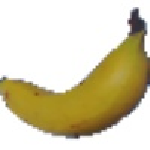

In [4]:
path = './data/fruits/train/Banana'
name = '274_100.jpg'
fullname = f'{path}/{name}'
img=load_img(fullname,target_size=(150, 150))
img

In [5]:
img.size

(150, 150)

In [6]:
x = np.array(img)
x.shape

(150, 150, 3)

Pre-train convolutional neural networks

In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [8]:
model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

2026-01-04 00:59:54.200250: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
X = np.array([x]) # Neural networks always expect batches, even if batch size=1, the dimension must exist

In [10]:
X.shape

(1, 150, 150, 3)

In [11]:
X = preprocess_input(X) # normalization Xception was trained with

In [12]:
pred = model.predict(X) # 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Transfer learning

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input) 


train_ds = train_gen.flow_from_directory( 
    './data/fruits/train',
    target_size=(150, 150),
    batch_size=32
) 
# loads fruit images from folders, resizes them, prepares them for Xception, and feeds them to the model in small batches.

Found 1947 images belonging to 5 classes.


In [15]:
train_ds.class_indices

{'Apple Golden 1': 0, 'Banana': 1, 'Mango': 2, 'Orange': 3, 'Strawberry': 4}

In [16]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './data/fruits/val',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)
# loads validation images, prepares them for Xception, resizes them, and feeds them to the model in a fixed order

Found 485 images belonging to 5 classes.


In [17]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False # lock pretrained weights


inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(5)(vectors)

model = keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [19]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [20]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        restore_best_weights=True
    )
]

history_1 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks
)


Epoch 1/10


2026-01-04 01:00:05.725203: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 22429696 exceeds 10% of free system memory.
2026-01-04 01:00:05.767627: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 42467328 exceeds 10% of free system memory.
2026-01-04 01:00:05.870247: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 21233664 exceeds 10% of free system memory.
2026-01-04 01:00:05.870368: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 42467328 exceeds 10% of free system memory.
2026-01-04 01:00:05.914846: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 84934656 exceeds 10% of free system memory.


61/61 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9820 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 2.4049e-06
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 1.0000 - loss: 8.2576e-06 - val_accuracy: 1.0000 - val_loss: 1.5187e-06
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 1.0000 - loss: 5.5722e-06 - val_accuracy: 1.0000 - val_loss: 1.1567e-06


In [22]:
print(history_1.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


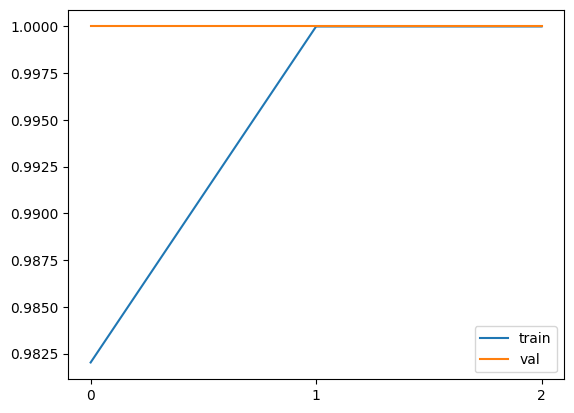

In [24]:
plt.plot(history_1.history['accuracy'], label='train')
plt.plot(history_1.history['val_accuracy'], label='val')
n = len(history_1.history['accuracy'])
plt.xticks(np.arange(n))
plt.legend()

Check potential issues test/val data duplications

In [25]:
x, y = next(train_ds)

print(x.shape)
print(y[:20])

(32, 150, 150, 3)
[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [26]:
print("train samples:", train_ds.samples)
print("val samples:", val_ds.samples)
print("train classes:", train_ds.num_classes)
print("val classes:", val_ds.num_classes)
print("class indices:", train_ds.class_indices)

train samples: 1947
val samples: 485
train classes: 5
val classes: 5
class indices: {'Apple Golden 1': 0, 'Banana': 1, 'Mango': 2, 'Orange': 3, 'Strawberry': 4}


In [27]:
train_files = set(train_ds.filenames)
val_files = set(val_ds.filenames)

overlap = train_files.intersection(val_files)
print("overlap count:", len(overlap))
print("sample overlaps:", list(overlap)[:10])

overlap count: 0
sample overlaps: []


In [28]:
import os, hashlib

def md5(path, chunk_size=8192):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

train_dir = train_ds.directory
val_dir = val_ds.directory

# hash all training images
train_hashes = {}
for fn in train_ds.filenames:
    train_hashes[md5(os.path.join(train_dir, fn))] = fn

# check validation images against training hashes
dups = []
for fn in val_ds.filenames:
    h = md5(os.path.join(val_dir, fn))
    if h in train_hashes:
        dups.append((train_hashes[h], fn))

print("exact duplicate images:", len(dups))
print("examples:", dups[:10])

exact duplicate images: 0
examples: []


Change EarlyStopping to monitor val_loss instead

In [29]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )
]

history_2 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 1.0000 - loss: 7.8720e-06 - val_accuracy: 1.0000 - val_loss: 1.3675e-06
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 1.0000 - loss: 4.7887e-06 - val_accuracy: 1.0000 - val_loss: 9.8118e-07
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 1.0000 - loss: 3.5104e-06 - val_accuracy: 1.0000 - val_loss: 7.5629e-07
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 1.0000 - loss: 2.7325e-06 - val_accuracy: 1.0000 - val_loss: 6.3758e-07
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 1.0000 - loss: 2.2412e-06 - val_accuracy: 1.0000 - val_loss: 5.4983e-07
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 1.0000 - loss: 1.9112e-06 - val_accuracy: 1.0000 - val_loss: 4.7192e-07
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 1.0000 - loss: 1.6472e-06 - val_accuracy: 1.0000 - val_loss: 4.1833e-07
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - ac

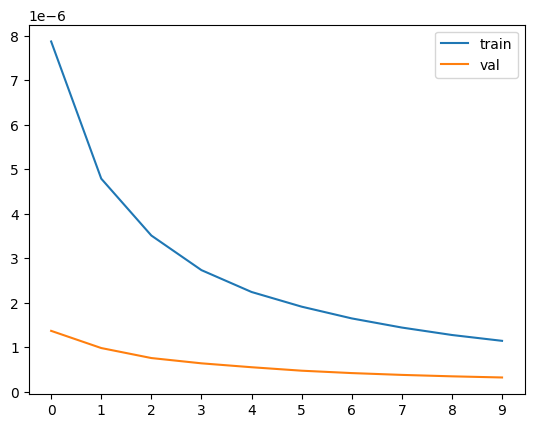

In [30]:
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='val')

m = len(history_2.history['loss'])
plt.xticks(np.arange(m))
plt.legend()

Use epoch =6 as a good trade-off time, accuracy = 1, val_loss = 4.7192e-07, which is already low

Adjust the learning rate

In [31]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(5)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [32]:
scores = {}

for lr in [0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history_3 = model.fit(train_ds, epochs=6, validation_data=val_ds)
    scores[lr] = history_3.history

    print()

0.001
Epoch 1/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9646 - loss: 0.1550 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 2/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 3/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 4/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 9.5623e-04

0.01
Epoch 1/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9831 - loss: 0.0395 - val_accuracy: 1.0000 - val_loss: 2.2166e-06
Epoch 2/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 1.0000 - loss: 5.6012e-06 - val_accu

In [36]:
learning_rate = 0.01

validation accuracy is 1.000 for all three, choose 0.01 for Fast, stable, very low loss

val_accuracy is always 1.0

It can’t distinguish which epoch is best

val_loss keeps decreasing → meaningful signal

Checkpoint save the best model only train a model with callbacks

In [38]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

In [40]:
learning_rate = 0.01
model = make_model(learning_rate=learning_rate)

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=6,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9414 - loss: 0.1553

61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9872 - loss: 0.0346 - val_accuracy: 1.0000 - val_loss: 2.7676e-07
Epoch 2/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 9.3180e-07

61/61 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 1.0000 - loss: 3.7657e-06 - val_accuracy: 1.0000 - val_loss: 2.3842e-07
Epoch 3/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 8.8227e-06

61/61 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 1.0000 - loss: 3.1838e-06 - val_accuracy: 1.0000 - val_loss: 1.9835e-07
Epoch 4/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.1746e-06

61/61 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 1.0000 - loss: 2.2063e-06 - val_accuracy: 1.0000 - val_loss: 1.8115e-07
Epoch 5/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.4277e-06

61/61 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 1.0000 - loss: 1.8751e-06 - val_accuracy: 1.0000 - val_loss: 1.6738e-07
Epoch 6/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.6833e-06

61/61 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 1.0000 - loss: 1.5684e-06 - val_accuracy: 1.0000 - val_loss: 1.5092e-07


Experiment with different sizes of inner layer

In [41]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(5)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [43]:
learning_rate = 0.01

scores = {}

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

for size in [10, 100, 300]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history_4 = model.fit(train_ds, epochs=6, validation_data=val_ds, callbacks=[early_stop],verbose=1)
    scores[size] = history_4.history

    print()

10
Epoch 1/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9743 - loss: 0.0811 - val_accuracy: 1.0000 - val_loss: 4.4110e-05
Epoch 2/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 1.0000 - loss: 1.4021e-05 - val_accuracy: 1.0000 - val_loss: 2.1848e-05
Epoch 3/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 1.0000 - loss: 9.7896e-06 - val_accuracy: 1.0000 - val_loss: 1.3968e-05
Epoch 4/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 1.0000 - loss: 8.5491e-06 - val_accuracy: 1.0000 - val_loss: 1.1182e-05
Epoch 5/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 1.0000 - loss: 7.6370e-06 - val_accuracy: 1.0000 - val_loss: 1.0107e-05
Epoch 6/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 1.0000 - loss: 7.1016e-06 - val_accuracy: 1.0000 - val_loss: 8.9640e-06

100
Epoch 1/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9784 - loss: 0.0556 - val_accuracy: 1.0000 - val_loss: 5.4074e-09
Epoch 2/6
61/61 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 

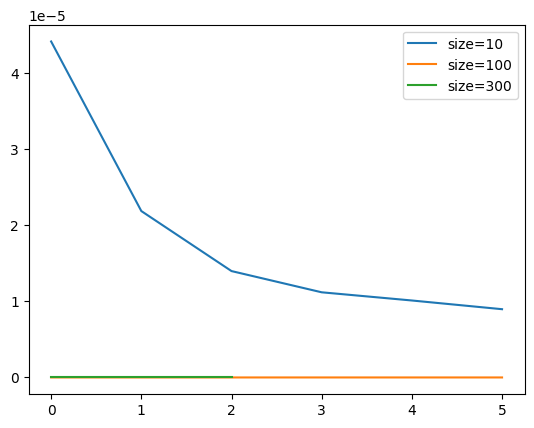

In [46]:
for size, hist in scores.items():
    plt.plot(hist['val_loss'], label=('size=%s' % size))

plt.xticks(np.arange(6))
plt.legend()

In [51]:
size_inner=100

compare validation loss and stability, size_inner=100 is the best

Regularization and dropout

Use epoch = 5 for time saving practice

In [52]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.2):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(5)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [53]:
learning_rate = 0.01
size = 100

scores = {}

for droprate in [0.0, 0.1, 0.2]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history_5 = model.fit(train_ds, epochs=5, validation_data=val_ds)
    scores[droprate] = history_5.history

    print()

0.0
Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9815 - loss: 0.0419 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 1.0000 - loss: 7.3473e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 1.0000 - loss: 4.8982e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 1.0000 - loss: 3.6736e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 1.0000 - loss: 3.0614e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00

0.1
Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9789 - loss: 0.0671 - val_accuracy: 1.0000 - val_loss: 2.4579e-10
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 1.0000 - loss: 2.4780e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy:

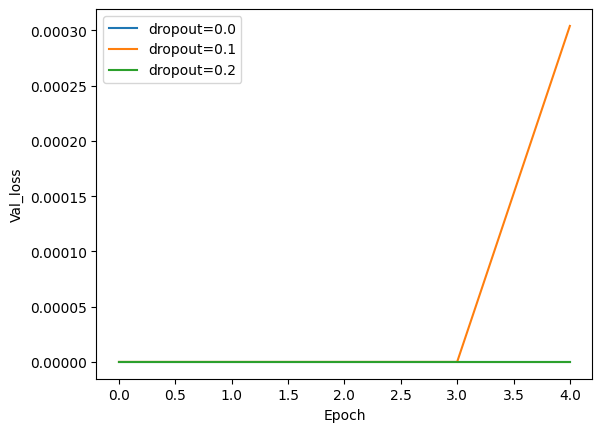

In [54]:
for droprate, hist in scores.items():
    plt.plot(hist['val_loss'], label=('dropout=%s' % droprate))

plt.xlabel("Epoch")
plt.ylabel("Val_loss")
plt.legend()

dropout=0.0

All three runs get val_accuracy = 1.0000, so accuracy can’t decide.

droprate = 0.1 is worse / unstable: train accuracy drops and train loss jumps later, and get a non-zero val_loss spike at epoch 5 (3.0398e-04). That’s a sign the training is getting noisy.

droprate = 0.2 also doesn’t improve anything — it’s still perfect on val, so dropout isn’t giving you extra benefit here.

So the best choice is the simplest + most stable: dropout=0.0

Data augmentation

In [55]:
# recreate train_ds with augmentation
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './data/fruits/train',
    target_size=(150, 150),
    batch_size=32,
    shuffle=True
)

# reuse existing val_ds without augmentation

Found 1947 images belonging to 5 classes.


In [56]:
learning_rate = 0.01
size = 100
droprate = 0.0

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history_6 = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9733 - loss: 0.1108 - val_accuracy: 0.9814 - val_loss: 0.0939
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 1.0000 - loss: 1.2988e-05 - val_accuracy: 1.0000 - val_loss: 3.1953e-09
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 1.0000 - loss: 7.4697e-09 - val_accuracy: 1.0000 - val_loss: 3.1953e-09
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 1.0000 - loss: 2.2784e-07 - val_accuracy: 1.0000 - val_loss: 2.9495e-09
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 1.0000 - loss: 2.8164e-09 - val_accuracy: 1.0000 - val_loss: 2.9495e-09


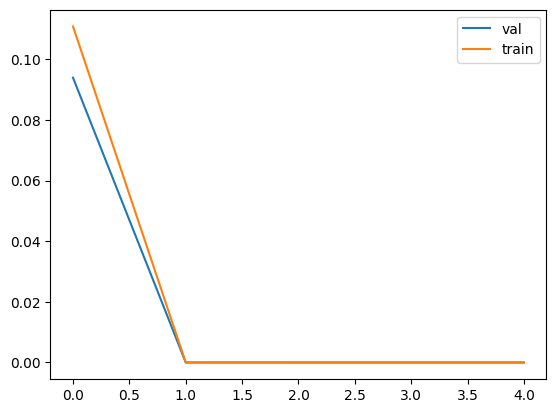

In [58]:
hist = history_6.history
plt.plot(hist['val_loss'], label='val')
plt.plot(hist['loss'], label='train')

plt.legend()

Fruits dataset is:

clean

visually separable

low noise

not prone to overfitting

Result:

augmentation does not improve final accuracy

validation loss saturates almost immediately

Final recommendation:

Keep light augmentation, safer if test data differs

Save final model

In [66]:
learning_rate = 0.01
size_inner = 100
droprate = 0.0

model = make_model(
    learning_rate=learning_rate,
    size_inner=size_inner,
    droprate=droprate
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_fruits_final.h5',  
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    train_ds,                     # augmented training data
    validation_data=val_ds,
    epochs=5,                   
    callbacks=[checkpoint, early_stop]
)

Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9151 - loss: 0.1964
Epoch 1: val_loss improved from None to 0.00000, saving model to xception_fruits_final.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.9795 - loss: 0.0612 - val_accuracy: 1.0000 - val_loss: 1.7205e-09
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9999 - loss: 5.0480e-04
Epoch 2: val_loss did not improve from 0.00000
61/61 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9990 - loss: 0.0242 - val_accuracy: 0.9856 - val_loss: 0.0463
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 4.7649e-04
Epoch 3: val_loss did not improve from 0.00000
61/61 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 3.9327e-08


Use the model

In [67]:
import tensorflow as tf
from tensorflow import keras

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

In [69]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './data/fruits/test',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 816 images belonging to 5 classes.


In [70]:
model = keras.models.load_model('xception_fruits_final.h5')

In [71]:
model.evaluate(test_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 1.0000 - loss: 2.4894e-06


[2.489428197804955e-06, 1.0]

In [72]:
path = 'data/fruits/test/Mango/11_100.jpg'

In [73]:
img = load_img(path, target_size=(150, 150))

In [74]:
import numpy as np

In [75]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 150, 150, 3)

In [76]:
X = preprocess_input(X)

In [77]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


In [78]:
class_indices = test_ds.class_indices
print(class_indices)

{'Apple Golden 1': 0, 'Banana': 1, 'Mango': 2, 'Orange': 3, 'Strawberry': 4}


In [79]:
dict(zip(class_indices, pred[0]))

{'Apple Golden 1': np.float32(-7.520343),
 'Banana': np.float32(-19.573755),
 'Mango': np.float32(75.61748),
 'Orange': np.float32(-38.76978),
 'Strawberry': np.float32(-19.70886)}

The model predict correctly as "Mango" for mannual test